<a href="https://colab.research.google.com/github/subhayughoshal/Prediction-Models_using_ML/blob/main/IPL_WINNING_TEAM_PREDICTION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [74]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error, accuracy_score, classification_report
import warnings
warnings.filterwarnings("ignore")


In [75]:
ipl_df = pd.read_csv('ipl_colab.csv')

# Data Cleaning

Remove duplicate rows


In [76]:
ipl_df = ipl_df.drop_duplicates()

In [77]:
ipl_df.shape

(76014, 15)

Handle missing values by filling with 0 where appropriate

In [78]:
ipl_df['runs'] = ipl_df['runs'].fillna(0)
ipl_df['wickets'] = ipl_df['wickets'].fillna(0)


In [79]:
ipl_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76014 entries, 0 to 76013
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   mid             76014 non-null  int64  
 1   date            76014 non-null  object 
 2   venue           76014 non-null  object 
 3   batting_team    76014 non-null  object 
 4   bowling_team    76014 non-null  object 
 5   batsman         76014 non-null  object 
 6   bowler          76014 non-null  object 
 7   runs            76014 non-null  int64  
 8   wickets         76014 non-null  int64  
 9   overs           76014 non-null  float64
 10  runs_last_5     76014 non-null  int64  
 11  wickets_last_5  76014 non-null  int64  
 12  striker         76014 non-null  int64  
 13  non-striker     76014 non-null  int64  
 14  total           76014 non-null  int64  
dtypes: float64(1), int64(8), object(6)
memory usage: 8.7+ MB


-Fix inconsistencies in 'overs' column (e.g., duplicate overs like 0.2 appearing twice)

-Create a delivery_number column to track sequence within each match

In [80]:
ipl_df.describe()

,mid,runs,wickets,overs,runs_last_5,wickets_last_5,striker,non-striker,total
count,76014.000000,76014.000000,76014.000000,76014.000000,76014.000000,76014.000000,76014.000000,76014.000000,76014.000000
mean,308.627740,74.889349,2.415844,9.783068,33.216434,1.120307,24.962283,8.869287,160.901452
std,178.156878,48.823327,2.015207,5.772587,14.914174,1.053343,20.079752,10.795742,29.246231
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,67.000000
25%,154.000000,34.000000,1.000000,4.600000,24.000000,0.000000,10.000000,1.000000,142.000000
50%,308.000000,70.000000,2.000000,9.600000,34.000000,1.000000,20.000000,5.000000,162.000000
75%,463.000000,111.000000,4.000000,14.600000,43.000000,2.000000,35.000000,13.000000,181.000000
max,617.000000,263.000000,10.000000,19.600000,113.000000,7.000000,175.000000,109.000000,263.000000


## Define Teams

In [81]:
# Fix inconsistent team names
ipl_df['batting_team'] = ipl_df['batting_team'].replace({
    'Rising Pune Supergiant': 'Rising Pune Supergiants'
})
ipl_df['bowling_team'] = ipl_df['bowling_team'].replace({
    'Rising Pune Supergiant': 'Rising Pune Supergiants'
})

## --- Visualization ---

### Distribution of Total Scores

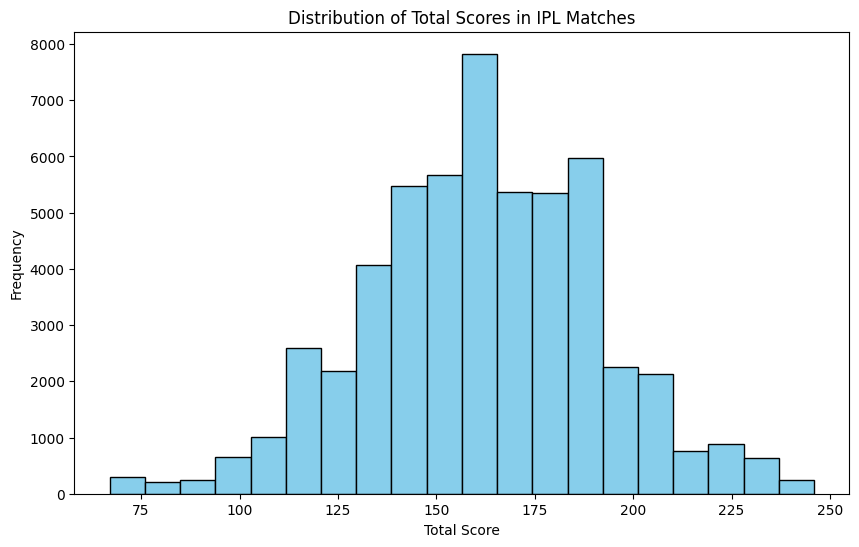

In [82]:
plt.figure(figsize=(10, 6))
plt.hist(df['total'], bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Total Score')
plt.ylabel('Frequency')
plt.title('Distribution of Total Scores in IPL Matches')
plt.savefig('total_scores_distribution.png')
plt.show()

### Cumulative Runs Over Deliveries for a Sample Match (mid=1)

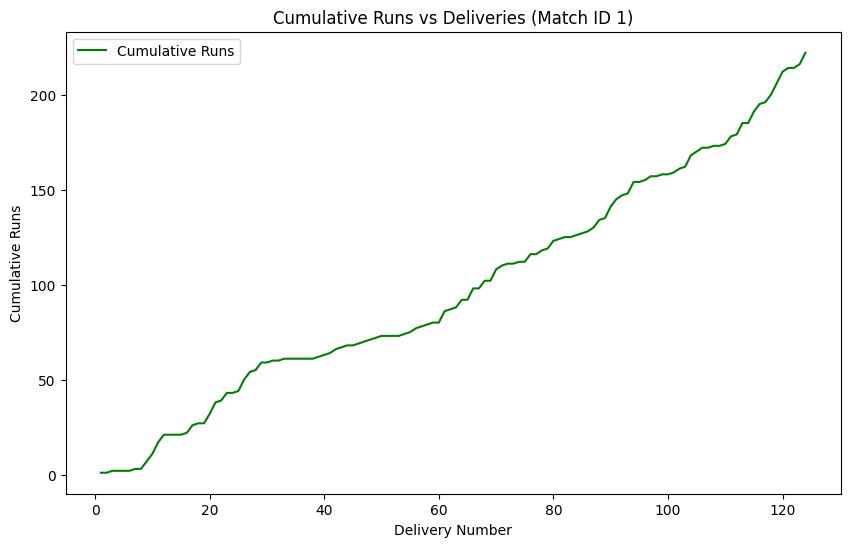

In [83]:
sample_match = df[df['mid'] == 1]
plt.figure(figsize=(10, 6))
plt.plot(sample_match['delivery_number'], sample_match['runs'], label='Cumulative Runs', color='green')
plt.xlabel('Delivery Number')
plt.ylabel('Cumulative Runs')
plt.title('Cumulative Runs vs Deliveries (Match ID 1)')
plt.legend()
plt.savefig('cumulative_runs_match1.png')
plt.show()

###Average Final Score per Team

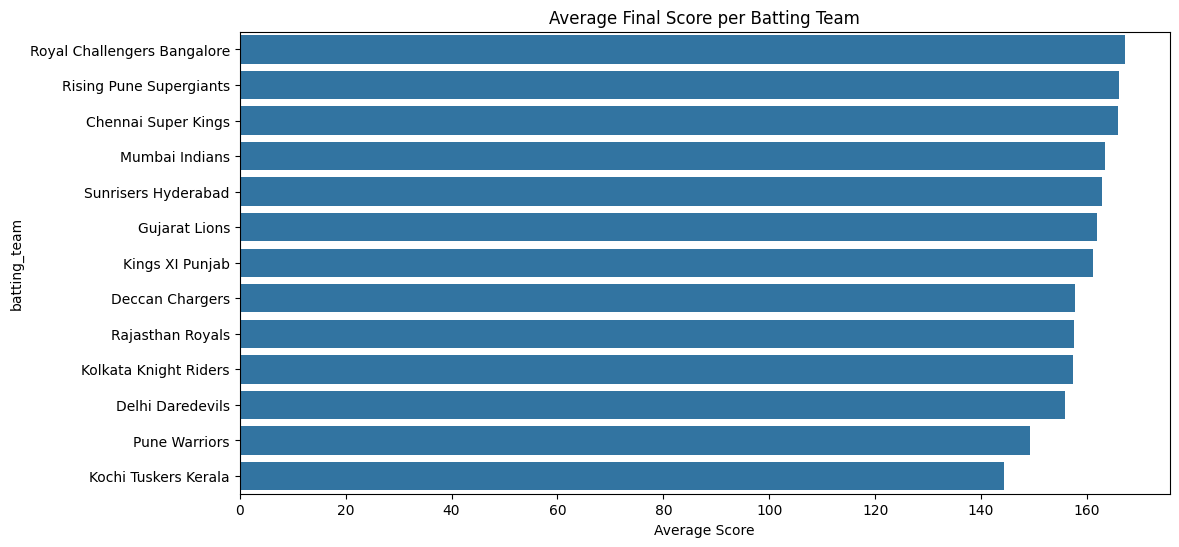

In [84]:
plt.figure(figsize=(12,6))
avg_total = ipl_df.groupby("batting_team")["total"].mean().sort_values(ascending=False)
sns.barplot(x=avg_total.values, y=avg_total.index)
plt.title("Average Final Score per Batting Team")
plt.xlabel("Average Score")
plt.show()

###Score progression over overs

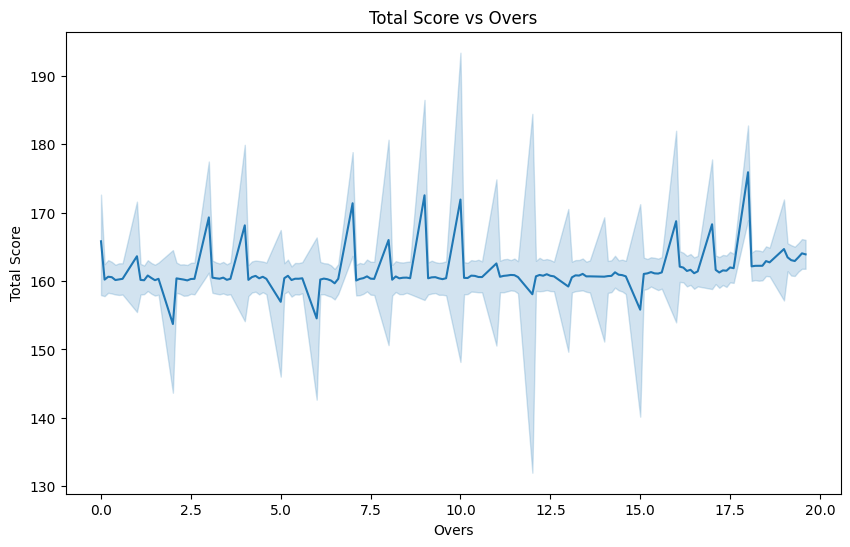

In [85]:
plt.figure(figsize=(10,6))
sns.lineplot(data=ipl_df, x="overs", y="total")
plt.title("Total Score vs Overs")
plt.xlabel("Overs")
plt.ylabel("Total Score")
plt.show()

In [86]:
# Use only top 8 consistent teams (optional for realistic filtering)
consistent_teams = [
    'Kolkata Knight Riders', 'Chennai Super Kings', 'Rajasthan Royals',
    'Mumbai Indians', 'Kings XI Punjab', 'Royal Challengers Bangalore',
    'Delhi Daredevils', 'Sunrisers Hyderabad'
]

# Filter dataset
ipl_df = ipl_df[
    (ipl_df['batting_team'].isin(consistent_teams)) &
    (ipl_df['bowling_team'].isin(consistent_teams))
]

# One-Hot Encoding
encoded_df = pd.get_dummies(ipl_df, columns=['batting_team', 'bowling_team'])


## **Score Prediction Model (Regression)**

In [87]:
# Features and target
X = encoded_df.drop(['total', 'date', 'venue', 'batsman', 'bowler', 'mid'], axis=1)
y = encoded_df['total']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Linear Regression Model
reg_model = LinearRegression()
reg_model.fit(X_train, y_train)

# Predictions
y_pred = reg_model.predict(X_test)

# Compare predicted vs actual
score_df = pd.DataFrame({"Actual": y_test, "Predicted": y_pred.round(0)})
print(score_df.head(10))

# Evaluation
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae:.2f}")


       Actual  Predicted
8745      119      151.0
20334     192      210.0
61914     202      196.0
70995     168      159.0
61850     202      178.0
58181     192      199.0
34594     141      178.0
19107     174      155.0
1810      178      157.0
7682      150      143.0
Mean Absolute Error: 15.55


### **--- Determine Winner for Each Match ---**

In [88]:
# For simplicity, we'll label the winner as the team with higher `total` per match
match_totals = ipl_df.groupby(['mid', 'batting_team'])['total'].max().reset_index()
match_wide = match_totals.pivot(index='mid', columns='batting_team', values='total').fillna(0)

# Identify winner
match_wide['winner'] = match_wide.apply(lambda x: x.idxmax(), axis=1)

# Encode match winner as y, and team totals as X
X_cls = match_wide.drop('winner', axis=1)
y_cls = match_wide['winner']

# Split
X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(X_cls, y_cls, test_size=0.2, random_state=42)

# Train Classifier
clf = RandomForestClassifier()
clf.fit(X_train_cls, y_train_cls)

# Predict & Evaluate
y_pred_cls = clf.predict(X_test_cls)
print("Accuracy:", accuracy_score(y_test_cls, y_pred_cls))
print("\nClassification Report:\n", classification_report(y_test_cls, y_pred_cls))


Accuracy: 1.0

Classification Report:
                              precision    recall  f1-score   support

        Chennai Super Kings       1.00      1.00      1.00        12
           Delhi Daredevils       1.00      1.00      1.00        12
            Kings XI Punjab       1.00      1.00      1.00         9
      Kolkata Knight Riders       1.00      1.00      1.00         9
             Mumbai Indians       1.00      1.00      1.00        12
           Rajasthan Royals       1.00      1.00      1.00        12
Royal Challengers Bangalore       1.00      1.00      1.00        14
        Sunrisers Hyderabad       1.00      1.00      1.00         8

                   accuracy                           1.00        88
                  macro avg       1.00      1.00      1.00        88
               weighted avg       1.00      1.00      1.00        88



In [94]:
# Predict on test set
y_pred = reg_model.predict(X_test)

# Create comparison DataFrame
comparison_df = pd.DataFrame({
    'Actual Score': y_test.values,
    'Predicted Score': y_pred.round(1)
})

# Add error column
comparison_df['Error'] = comparison_df['Predicted Score'] - comparison_df['Actual Score']

# Show first few rows
print("🔍 Predicted vs Actual Scores:")
print(comparison_df.head(10))


🔍 Predicted vs Actual Scores:
   Actual Score  Predicted Score  Error
0           119            150.5   31.5
1           192            210.4   18.4
2           202            195.7   -6.3
3           168            158.9   -9.1
4           202            177.8  -24.2
5           192            199.1    7.1
6           141            177.6   36.6
7           174            155.5  -18.5
8           178            156.7  -21.3
9           150            142.9   -7.1


In [92]:
# Create base input dictionary
input_data = {
    'overs': 10,
    'runs': 80,
    'wickets': 2,
    'runs_last_5': 45,
    'wickets_last_5': 1,
    'striker': 20,
    'non-striker': 15
}

# Teams for one-hot encoding
bat_team = 'Mumbai Indians'
bowl_team = 'Chennai Super Kings'

# Create a full column list like X_train.columns
input_columns = X_train.columns

# Initialize with zeros
input_vector = pd.DataFrame(data=np.zeros((1, len(input_columns))), columns=input_columns)

# Fill numeric features
for key in input_data:
    if key in input_vector.columns:
        input_vector[key] = input_data[key]

# Fill team one-hot encodings
bat_col = f'batting_team_{bat_team}'
bowl_col = f'bowling_team_{bowl_team}'

if bat_col in input_vector.columns:
    input_vector[bat_col] = 1
if bowl_col in input_vector.columns:
    input_vector[bowl_col] = 1

# Predict
predicted_score = reg_model.predict(input_vector)[0]
print(f"🏏 Predicted Final Score: {predicted_score:.2f}")


🏏 Predicted Final Score: 171.13


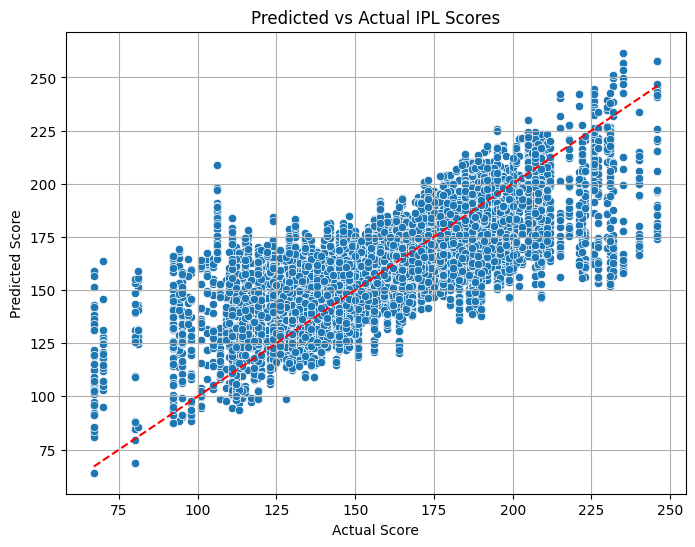

In [95]:
# Scatter plot to visualize predicted vs actual
plt.figure(figsize=(8,6))
sns.scatterplot(x='Actual Score', y='Predicted Score', data=comparison_df)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # reference line
plt.title('Predicted vs Actual IPL Scores')
plt.xlabel('Actual Score')
plt.ylabel('Predicted Score')
plt.grid(True)
plt.show()
